In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Create category id to name mapping
        self.categories = {cat['id']: cat['name'] 
                         for cat in self.annotations['categories']}
        
        # Store image information
        self.images = self.annotations['images']
    
    def __getitem__(self, idx):
        try:
            # Get image info
            img_info = self.images[idx]
            img_path = os.path.join(self.image_dir, img_info['file_name'])
            
            # Load image
            image = Image.open(img_path).convert('RGB')
            
            # Get annotations for this image
            img_annots = [ann for ann in self.annotations['annotations'] 
                         if ann['image_id'] == img_info['id']]
            
            # Prepare target
            boxes = []
            labels = []
            for ann in img_annots:
                boxes.append(ann['bbox'])  # [x, y, width, height]
                labels.append(ann['category_id'])
            
            # Convert to tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            
            # Convert boxes from [x, y, w, h] to [x1, y1, x2, y2]
            if len(boxes) > 0:
                boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
                boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([img_info['id']])
            }
            
            if self.transform is not None:
                image = self.transform(image)
            
            return image, target
        
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            raise
    
    def __len__(self):
        return len(self.images)

def get_predictions(model, dataloader, device='cpu', confidence_threshold=0.5, max_dets_per_image=100):
    """
    Get predictions from the model for all images in the dataloader
    
    Parameters:
    -----------
    model : torch.nn.Module
        The Faster R-CNN model
    dataloader : torch.utils.data.DataLoader
        Dataloader containing the validation/test dataset
    device : str
        Device to run inference on ('cpu' or 'cuda')
    confidence_threshold : float
        Threshold for keeping predictions
    max_dets_per_image : int
        Maximum number of detections to keep per image
    """
    model = model.to(device)
    model.eval()
    
    all_gt_labels = []
    all_pred_labels = []
    
    print("Starting inference...")
    
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Running inference"):
            # Move images and targets to device
            images = [image.to(device) for image in images]
            
            # Get predictions
            predictions = model(images)
            
            # Process each image's predictions and ground truths
            for pred, target in zip(predictions, targets):
                # Sort predictions by score and keep top K
                scores = pred['scores']
                if len(scores) > 0:
                    sorted_idxs = torch.argsort(scores, descending=True)
                    sorted_idxs = sorted_idxs[:max_dets_per_image]
                    
                    # Get predictions above threshold from top K
                    keep = scores[sorted_idxs] > confidence_threshold
                    pred_labels = pred['labels'][sorted_idxs][keep].cpu().numpy()
                else:
                    pred_labels = np.array([])
                
                # Get ground truth labels
                gt_labels = target['labels'].cpu().numpy()
                
                # Make sure we have equal numbers of predictions and ground truths
                num_gt = len(gt_labels)
                num_pred = len(pred_labels)
                
                if num_pred < num_gt:
                    # Pad predictions with a background class (0)
                    pred_labels = np.pad(pred_labels, (0, num_gt - num_pred), 
                                      mode='constant', constant_values=0)
                elif num_pred > num_gt:
                    # Truncate predictions
                    pred_labels = pred_labels[:num_gt]
                
                # Store labels
                all_gt_labels.extend(gt_labels)
                all_pred_labels.extend(pred_labels)
    
    print(f"Total ground truth labels: {len(all_gt_labels)}")
    print(f"Total predictions: {len(all_pred_labels)}")
    
    return all_gt_labels, all_pred_labels

def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title='Confusion Matrix', figsize=(12, 10)):
    """
    Plot confusion matrix
    """
    # Make sure we have labels for all classes
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     fmt = '.2f'
    # else:
    #     fmt = 'd'
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    
    return plt

def evaluate_model(model, image_dir, annotation_file, batch_size=4, confidence_threshold=0.5):
    """
    Evaluate model on dataset and create confusion matrix
    """
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Create dataset and dataloader
    dataset = COCODataset(
        image_dir=image_dir,
        annotation_file=annotation_file,
        transform=transform
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    )
    
    # Get predictions
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    y_true, y_pred = get_predictions(
        model=model,
        dataloader=dataloader,
        device=device,
        confidence_threshold=confidence_threshold
    )
    
    # Get class names from dataset
    classes = ['background'] + list(dataset.categories.values())
    
    # Create and plot confusion matrix
    plt = plot_confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        classes=classes,
        normalize=True,
        title='Faster R-CNN Confusion Matrix'
    )
    
    return plt, y_true, y_pred

C:\Users\BERNARD OWENS W\AppData\Local\Temp\ipykernel_40112\46451774.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locati

Using device: cpu
Starting inference...


Running inference: 100%|██████████| 21/21 [02:15<00:00,  6.45s/it]


Total ground truth labels: 760
Total predictions: 760


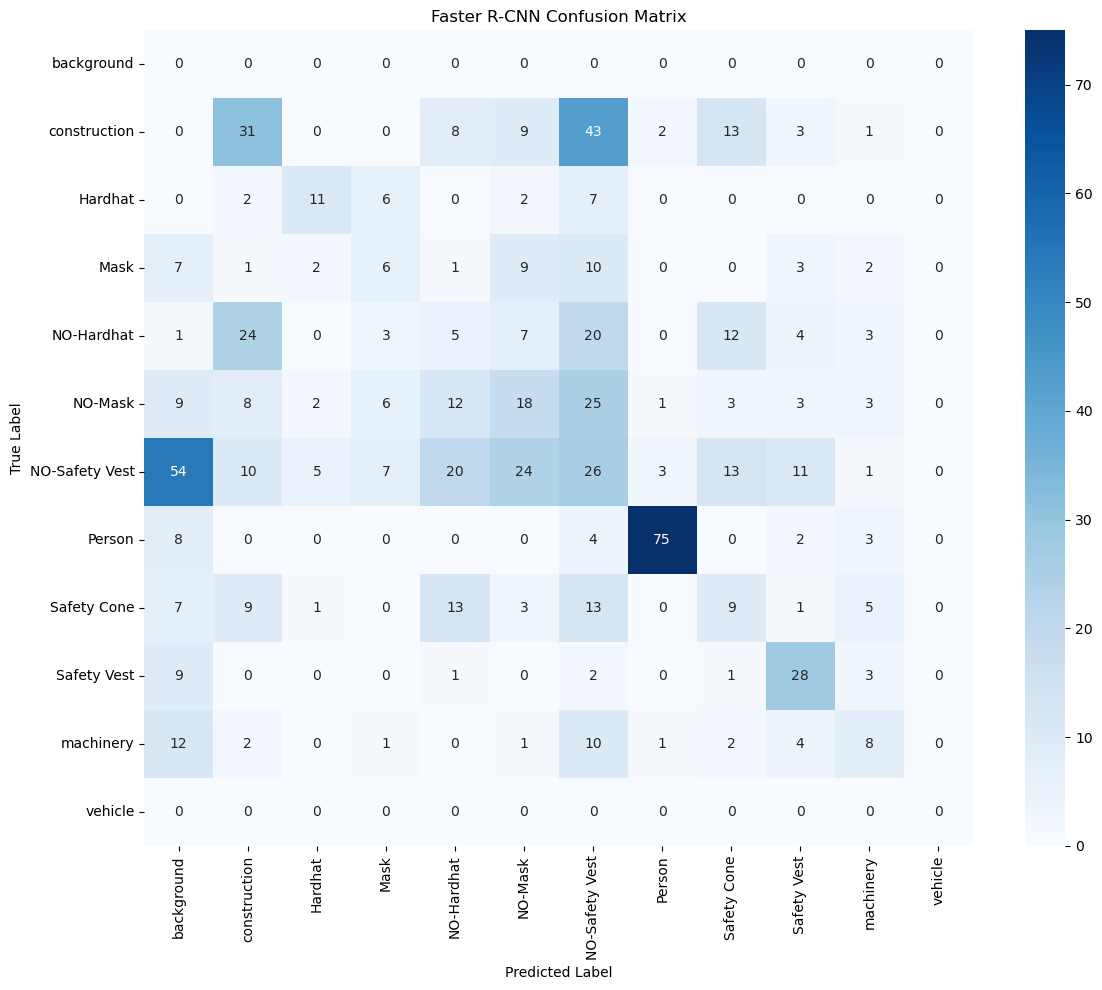

In [2]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import os

# Define paths
data_dir = r"C:\Users\BERNARD OWENS W\Downloads\Construction Site Safety.v27-yolov8s.coco\test"
image_dir = data_dir  # Images are in the same directory
annotation_file = os.path.join(data_dir, r"C:\Users\BERNARD OWENS W\Downloads\Construction Site Safety.v27-yolov8s.coco\test\_annotations.coco.json")

# Your existing model loading code
checkpoint_path = r"C:\Kuliah\CV\FasterRCNN-Torchvision-FineTuning-main\FasterRCNN-Torchvision-FineTuning-main\fasterrcnn_resnet50_epoch_25.pth"
num_classes = 11  # Update with the number of classes in your model
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(weights=None, num_classes=num_classes)
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU or modify to use CUDA
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)  # Use the checkpoint directly
model.eval()

# Run evaluation using the code from the previous artifact
plt, y_true, y_pred = evaluate_model(
    model=model,
    image_dir=image_dir,
    annotation_file=annotation_file,
    batch_size=4, # Adjust this based on your GPU memory
    confidence_threshold=0.5
)

# Save the confusion matrix
output_path = os.path.join(data_dir, 'confusion_matrix.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()